In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline
import networkx as nx

# Part1: create data

In [2]:
def create_toroidal(k):
    G=nx.Graph()
    count = 0
    mapping1 = {}
    mapping2 = {}
    for i in range(k):
        for j in range(k):
            mapping1[count] = (i,j)
            mapping2[(i,j)] = count
            G.add_node(count)
            count +=1
    for i in range(k):
        for j in range(k):
            if (i,j+1) in mapping2:
                G.add_edge(mapping2[(i,j)],mapping2[i,j+1])
            if (i,j-1) in mapping2:
                G.add_edge(mapping2[(i,j)],mapping2[i,j-1])
            if (i+1,j) in mapping2:
                G.add_edge(mapping2[(i,j)],mapping2[i+1,j])
            if (i-1,j) in mapping2:
                G.add_edge(mapping2[(i,j)],mapping2[i-1,j])  
    j = 0
    for i in range(k):
        G.add_edge(mapping2[(i,j)],mapping2[i,j+k-1])
    i = 0
    for j in range(k):
        G.add_edge(mapping2[(i,j)],mapping2[i+k-1,j])
    return G, mapping1, mapping2

/Users/danqing0703/anaconda/envs/python2/lib/python2.7/site-packages/networkx/drawing/nx_pylab.py:124: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/Users/danqing0703/anaconda/envs/python2/lib/python2.7/site-packages/networkx/drawing/nx_pylab.py:136: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/Users/danqing0703/anaconda/envs/python2/lib/python2.7/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/Users/danqing0703/anaconda/envs/python2/lib/python2.7/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes

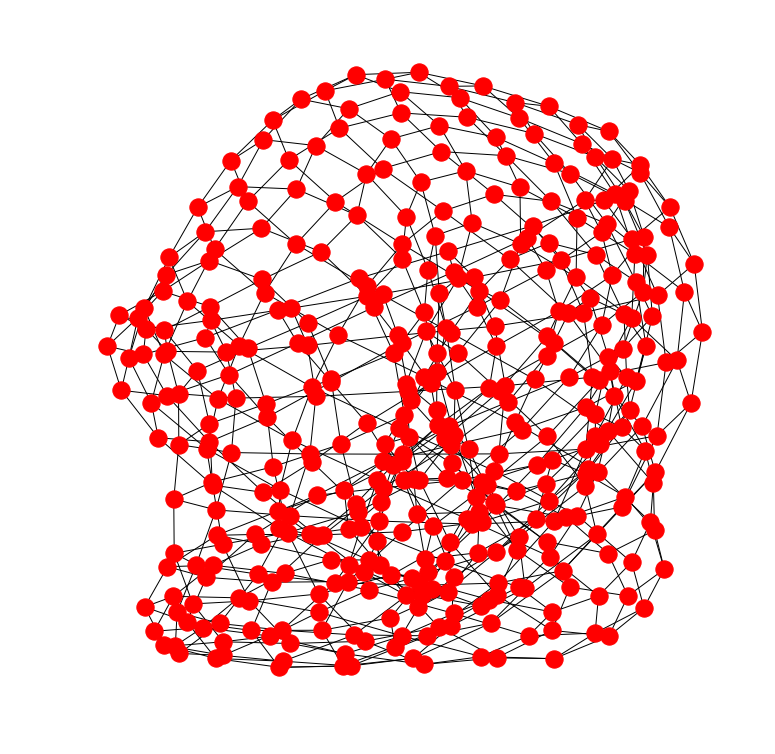

In [3]:
k = 20
G, mapping1,mapping2 = create_toroidal(k)
plt.figure(figsize=(10,10))
nx.draw(G)
plt.show()

# Part2 G is fixed

In [6]:
import tensorflow as tf
from numpy import random
dim = 12
d = 5
y = tf.constant(random.choice([0,1],G.number_of_nodes()).astype(np.float32))
x = tf.constant(np.random.rand(G.number_of_nodes(),dim).astype(np.float32))
train_id = tf.placeholder(tf.float32, [None, 1])
W1 = tf.Variable(tf.random_normal([d, dim],stddev=0.35))
W2 = tf.Variable(tf.random_normal([d, d],stddev=0.35))
u =  tf.Variable(tf.zeros([d]))
mus_initial = tf.constant(np.zeros([G.number_of_nodes(),d]).astype(np.float32))

In [7]:
def update_mus(mus, W1, W2, G, x):
    output_list = []
    for i in range(mus.shape[0]):
        output = tf.matmul(W1,tf.expand_dims(x[i],-1))
        for j in G.neighbors(i):
             output += tf.matmul(W2,tf.expand_dims(mus[j],-1))
        output_list.append(tf.squeeze(output))
    outputs = tf.stack(output_list)
    return outputs

In [9]:
mus = update_mus(mus_initial, W1, W2, G, x)

In [10]:
node_id = tf.placeholder(tf.int32, shape=[20,],name="input_node")
neighbors_adj = tf.placeholder(tf.int32, shape=[20*10,],name="input_node_neighors")
neighbors_mus = tf.nn.embedding_lookup(mus, neighbors_adj)
batch_y = tf.nn.embedding_lookup(y, node_id)

In [11]:
loss = tf.reduce_sum(tf.square(batch_y - tf.matmul(tf.sigmoid(tf.reduce_sum(tf.reshape(neighbors_mus,[20,10,5]), axis=1)),
                                            tf.expand_dims(u, 1))))

In [12]:
optimizer = tf.train.GradientDescentOptimizer(0.001).minimize(loss)

In [14]:
# generate bacth node id and neighbors_id

In [15]:
import random
batch_node_id = random.sample(G.nodes(),20)
from numpy import random
batch_neighbors_adj = []
for node in batch_node_id:
    batch_neighbors_adj.append(random.choice(G.neighbors(node),10))

In [25]:
sess = tf.Session()
epochs = 3
sess.run(tf.initialize_all_variables())
for step in xrange(epochs): 
    feed_dict ={node_id:batch_node_id, neighbors_adj:np.array(batch_neighbors_adj).flatten()}
    _, loss_val = sess.run([optimizer, loss], feed_dict=feed_dict)
    print(loss_val)
    mus = update_mus(mus, W1, W2, G, x)

Instructions for updating:
Use `tf.global_variables_initializer` instead.
160.0
145.38
135.945
